In [8]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from statistics import fmean, stdev

import os
import glob
import argparse
import math
import numpy as np

matplotlib.rc('font', family='Times New Roman', serif='cm10')
matplotlib.rc('mathtext', fontset='cm')
plt.rcParams['text.usetex'] = False
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rc('font', family='Times New Roman', serif='cm10')
# matplotlib.rc('mathtext', fontset='cm')

examples_per_class = [1,2,4,8,16]
trials = [0,1,2,3]

baselines = {
    "coco": {
        "da": [0.625, 0.7, 0.733, 0.75, 0.775],
        "real_guidance": [0.517, 0.633, 0.70, 0.741, 0.767]
    },
    "pascal": {
        "da": [0.657, 0.735, 0.764, 0.792, 0.821],
        "real_guidance": [0.593, 0.696, 0.75, 0.796, 0.822]
    }
}

def format_text(text):
    text = text.replace("_", " ").title()
    return text

In [71]:
def plot_all_cond_methods(dataset_dir, cond_methods):
    examples_per_class = [1,2,4,8,16]
    trials = [0,1,2,3]
    accs = dict()

    for cond_method in cond_methods:
        accs[cond_method] = dict((ex, []) for ex in examples_per_class)
        img_dir = os.path.join(dataset_dir, cond_method)
        run_df = pd.read_csv(os.path.join(img_dir, "results_3_16.csv"), index_col=0)
        # only keep the val accuracy rows (one row per epoch)
        run_df = run_df.loc[(run_df['metric'] == 'Accuracy') & (run_df['split'] == "Validation")]

        for ex in examples_per_class:
            ex_df = run_df.loc[(run_df['examples_per_class'] == ex)]
            for trial in trials:
                trial_df = ex_df.loc[(ex_df['seed'] == trial)]
                val_accs = trial_df["value"].to_numpy()
                acc = val_accs.max()

                accs[cond_method][ex].append(acc)

    # calculate means and stds over trials
    for cond_method in cond_methods:
        for ex in examples_per_class:
                accs[cond_method][ex] = (fmean(accs[cond_method][ex]), stdev(accs[cond_method][ex]))

    # plotting
    plt.figure(figsize=(8, 6))
    for cond_method in accs:
        x = accs[cond_method].keys()
        means = np.array([accs[cond_method][ex][0] for ex in examples_per_class])
        stds = np.array([accs[cond_method][ex][1] for ex in examples_per_class])
        plt.plot(x, means, '--o', label=format_text(cond_method))
        plt.fill_between(x, means-stds, means+stds, alpha=0.2)
    
    plt.legend(prop={'size': 16, 'weight': 'bold'}, loc='lower right')
    plt.xlabel("Examples Per Class", fontsize=24, fontweight='bold', labelpad=12)
    plt.ylabel("Accuracy", fontsize=24, fontweight='bold', labelpad=12)
    plt.title(dataset_dir.split('/')[-1].title(), fontsize=24, fontweight='bold', pad=12)
    
    plt.grid(color='grey', linestyle='dotted', linewidth=2)
    plt.xticks(examples_per_class, examples_per_class)
    plt.show()
    
    return accs


# plot baselines + our best 
def plot_baselines(accs, best_cond_method, dataset):
    da_fusion = baselines[dataset]["da"]
    real_guidance = baselines[dataset]["real_guidance"]
    our_best = np.array([accs[best_cond_method][ex][0] for ex in examples_per_class])
    stds = np.array([accs[best_cond_method][ex][1] for ex in examples_per_class])
    
    plt.figure(figsize=(8, 6))
    x = examples_per_class
    plt.plot(x, da_fusion, '--o', label="DA Fusion")
    plt.plot(x, real_guidance, '--o', label="Real Guidance")
    plt.plot(x, our_best, '--o', label=format_text(best_cond_method), color='g')
    plt.fill_between(x, our_best-stds, our_best+stds, alpha=0.2, color='g')
    
    plt.legend(prop={'size': 16, 'weight': 'bold'}, loc='lower right')
    plt.xlabel("Examples Per Class", fontsize=24, fontweight='bold', labelpad=12)
    plt.ylabel("Accuracy", fontsize=24, fontweight='bold', labelpad=12)
    plt.title(dataset.title(), fontsize=24, fontweight='bold', pad=12)
    
    plt.grid(color='grey', linestyle='dotted', linewidth=2)
    plt.xticks(examples_per_class, examples_per_class)
    plt.show()

# Cond Methods

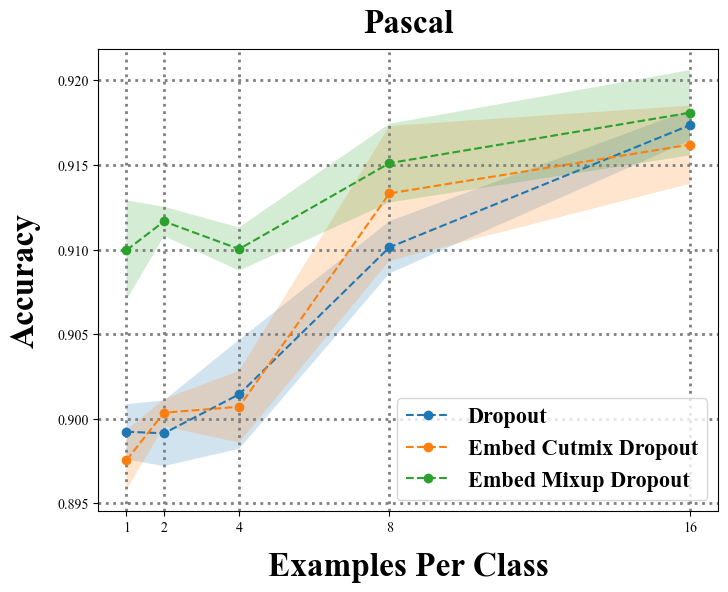

In [72]:
dataset_dir = "/datastor1/jiahuikchen/LT-classification/logs/pascal"
cond_methods = ["dropout", "embed_cutmix_dropout", "embed_mixup_dropout"]
pascal_accs = plot_all_cond_methods(dataset_dir, cond_methods)

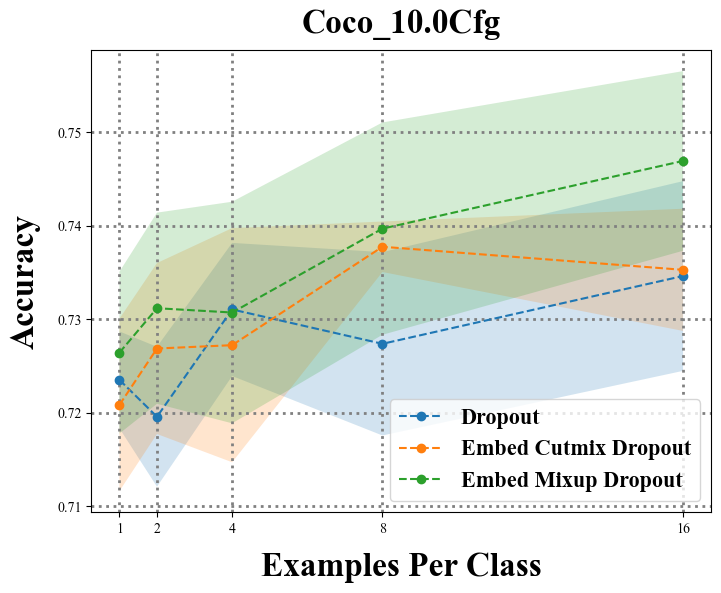

In [66]:
dataset_dir = "/datastor1/jiahuikchen/LT-classification/logs/coco_10.0cfg"
coco_accs = plot_all_cond_methods(dataset_dir, cond_methods)

# Baselines

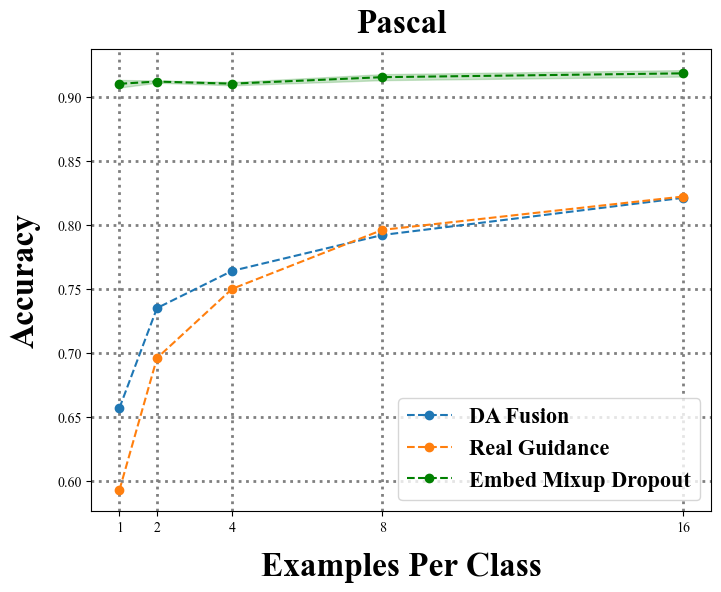

In [73]:
plot_baselines(pascal_accs, "embed_mixup_dropout", "pascal")

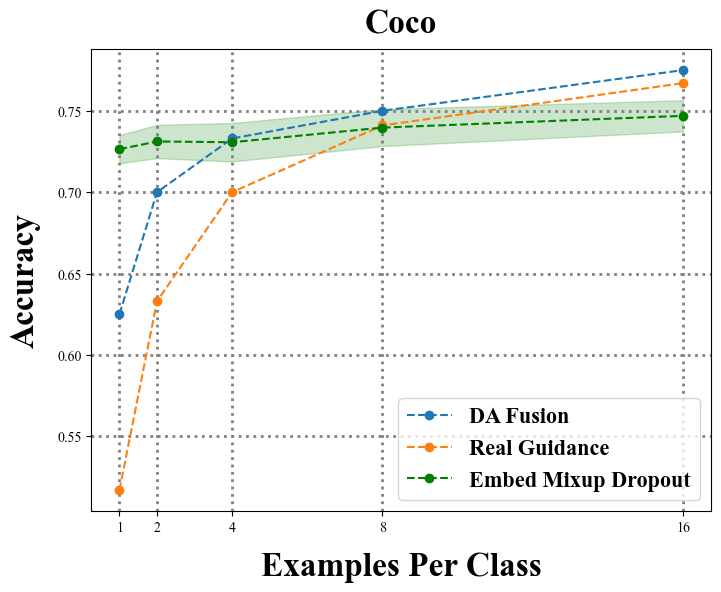

In [74]:
plot_baselines(coco_accs, "embed_mixup_dropout", "coco")